# Loadshape Electrification Analysis for Residential Sector by State
## Using NREL's ResStock, 2022 release of amy_2018_v1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import datetime as dt
import seaborn as sns
sns.set_theme()

from sg2t.io.loadshapes.nrel.api import API
from sg2t.io.loadshapes.nrel.naming import HOME_TYPES
from sg2t.utils.timeseries import Timeseries

from analysis_utils import format_columns_df, sigmoid, loadshape_analysis

# Loop over: years, states, hometypes

In [3]:
sector = "Resstock"

In [4]:
year_range = np.arange(2023, 2051)

In [5]:
data_model_year = 2018 # does not vary for this study

## Get data for all top states
- Residential:  New York, Illinois, California, Ohio, Michigan, Texas, Pennsylvania, and Massachusetts
- Commercial: New York, Illinois, California, Ohio, Michigan, Texas, Pennsylvania, and Florida

Divide states into three categories:
- those with a set target year and that have started adopting: CA, NY, MA, IL, MI, FL
- those with a set target year and will adopt: PA?
- those that have no target set (follow the market): OH, TX, all the others

## Import input values

In [6]:
with open('inputs.json', 'r') as openfile:
     inputs = json.load(openfile)

In [7]:
res_states = list(inputs["State Target Year"].keys())

In [8]:
state_start_year = inputs["State Start Year"]
state_target_year = inputs["State Target Year"]
states_tz =  inputs["State Timezone"]
state_heater_year =  inputs["State Heater Year"]
state_water_year =  inputs["State Water Year"]
state_clothes_year =  inputs["State Clothes Year"]
state_cooking_year =  inputs["State Cooking Year"]
state_heater_AR =  inputs["State Heater AR"]
state_water_AR =  inputs["State Water AR"]
state_clothes_AR =  inputs["State Clothes AR"]
state_cooking_AR = inputs["State Cooking AR"]

## Import NREL Stock data and format (for all states and hometypes)
#### Note that this dataset is missing some building types data for DC

If not cached it will pull from NREL API

In [12]:
api = API()
data = {}

for state in res_states:
    print(state)
    
    for hometype in HOME_TYPES:
        filename = f"./nrel_data/{sector}_{state}_{hometype}.csv"
        if not os.path.exists(filename):
        
            # Download data
            try:
                df = api.get_data_resstock_by_state(state, hometype)
            except:
                print("Missing ", state, hometype)
                continue # skip missing data and just add what is found
            df = format_columns_df(df)

            # Save locally
            try:
                df.to_csv(filename)
            except OSError:
                os.mkdir("./nrel_data")
                df.to_csv(filename)
            

        # Load cached data
        df = pd.read_csv(f"./nrel_data/{sector}_{state}_{hometype}.csv")
        df["Datetime"] = Timeseries.make_datetime(df["timestamp"])
        df = df.drop("timestamp", axis=1)
        df.sort_values("Datetime", inplace=True, ascending=True)
        df.set_index("Datetime", inplace=True, drop=True)
        data[f"{state}_{hometype}"] = df

NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
Missing  DC mobile_home
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY


In [14]:
data[f"{state}_{hometype}"].head()

,Electricity Cooling,Electricity Heating,Fuel Oil Heating,Fuel Oil Hot Water,Natural Gas Clothes Dryer,Natural Gas Heating,Natural Gas Hot Water,Natural Gas Oven,Propane Clothes Dryer,Propane Heating,Propane Hot Water,Propane Oven,Site Energy Total,Electricity Total,Fuel Oil Total,Natural Gas Total,Propane Total
Datetime,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,52.300299,8307.999309,0.0,0.0,0.0,8663.984978,1079.254898,0.0,0.0,0.0,0.0,0.0,22163.293037,12384.274908,0.0,9778.791635,0.0
2018-01-01 00:30:00,52.300299,8413.810561,0.0,0.0,0.0,8783.910073,1919.369221,0.0,0.0,0.0,0.0,0.0,23662.995385,12923.258542,0.0,10738.972976,0.0
2018-01-01 00:45:00,52.300299,8478.459542,0.0,0.0,0.0,8862.677443,1498.708886,0.0,0.0,0.0,0.0,0.0,23384.542087,12988.876047,0.0,10396.796165,0.0
2018-01-01 01:00:00,52.300299,8520.106076,0.0,0.0,0.0,8996.440050,2221.878500,0.0,0.0,0.0,0.0,0.0,24012.197394,12758.609454,0.0,11253.799348,0.0
2018-01-01 01:15:00,52.300299,8618.895529,0.0,0.0,0.0,8584.862799,1345.006071,0.0,0.0,0.0,0.0,0.0,22562.452009,12604.371999,0.0,9958.892163,0.0


## Start loop to get new supply for each state and hometype

In [17]:
results_resid = {} # Structure: results_resid[str_study_year][state][hometype]

In [18]:
plot_sigmoids = False

In [19]:
for study_year in year_range:
    str_study_year = str(study_year)
    # create dict for all years
    results_resid[str_study_year] = {}

In [ ]:
for study_year in year_range:
    print(study_year)
    str_study_year = str(study_year)
    
    for state in res_states:
        print(state)
        state_study_year = study_year
        results_resid[str_study_year][state] = {}
        
        # Set params for each state
        # Start year of electrification adoption
        start_year = state_start_year[state]
        # Target year
        target_year = state_target_year[state]
        # Peak adoption year per end use
        heater_year, water_year, clothes_year, cooking_year = state_heater_year[state], state_water_year[state], state_clothes_year[state], state_cooking_year[state]
        # Adoption rate per end use
        heater_AR, water_AR, clothes_AR, cooking_AR = state_heater_AR[state], state_water_AR[state], state_clothes_AR[state], state_cooking_AR[state]

        ########## Set Study Year #############
        x = np.arange(start_year, target_year + 1, 1)
        
        if state_study_year > target_year:
            # Assumed fully electrified
            state_study_year = target_year
            year_idx = list(x).index(target_year)
            
        if state_study_year in list(x):
            year_idx = list(x).index(state_study_year) 
        elif state_study_year < list(x)[0]:
            # Electrification has not started yet
            # Assume state is same as start year
            state_study_year = list(x)[0]
            year_idx = 0
            
        if str(state_study_year) != str_study_year:
            results_resid[str(state_study_year)][state] = {}
        #######################################

        aggregation = "avg" # "avg" or "peak_day"
        month_start = 1
        month_end = 12
        day_type = None
        timezone = states_tz[state]
        

        for hometype in HOME_TYPES:
            try:
                df = data[f"{state}_{hometype}"]
            except KeyError:
                if state=="DC":
                    continue
                else:
                    raise

            resstock_heating = df[['Fuel Oil Heating', 'Natural Gas Heating', 'Propane Heating']].sum(axis=1)
            resstock_water_heating = df[['Fuel Oil Hot Water','Natural Gas Hot Water','Propane Hot Water']].sum(axis=1)
            resstock_clothes_dryer = df[['Natural Gas Clothes Dryer', 'Propane Clothes Dryer']].sum(axis=1)
            resstock_oven = df[['Natural Gas Oven', 'Propane Oven']].sum(axis=1)

            appliance = [resstock_heating, resstock_water_heating, resstock_clothes_dryer, resstock_oven]

            initial_year = dt.datetime.now().year
            new_sup = np.zeros((100,4))
            final_val = np.zeros((100,4))
            X0 = [heater_year, water_year, clothes_year, cooking_year]
            K = [heater_AR, water_AR, clothes_AR, cooking_AR]


            # Applying arithmetic or geometric growth rate to achieve electrification
            
            if plot_sigmoids:    
                # Generate x values
                x = np.linspace(start_year, target_year, 100)
                new_sup = np.zeros((len(x),len(appliance)))
                for i in range(len(appliance)):
                    # Initial and target value
                    initial_value = appliance[i].sum()

                    # Calculate parameters
                    x0 = X0[i]
                    k = K[i]/100  # adjust this to suit your needs

                    
                    new_sup[:,i] = sigmoid(x, 1, k, x0)
                    new_sup[:,i] = (new_sup[:,i] - min(new_sup[:,i])) / (max(new_sup[:,i]) - min(new_sup[:,i])) 
                    
                    # If data_model_year > start_year, backpropagate data by appropriate growth amount to start at zero electrification at start_year
                    if data_model_year > start_year and data_model_year in x:
                        # Find growth amount at model year
                        model_year_idx = list(x).index(data_model_year)
                        model_year_supply_growth = new_sup[model_year_idx]
                        # Adjust what appliance initial consumption is by the growth at model year
                        initial_value /= model_year_supply_growth

                    # Get new supply
                    new_sup[:,i] = new_sup[:,i] * initial_value
                
                # Plot sigmoid functions
                plt.plot(x, new_sup[:,0]/1e9, color='tab:blue', label = 'Space heater')
                plt.axvline(x=X0[0],ls=':', color='tab:blue', label='Peak adoption year - space heater')

                plt.plot(x, new_sup[:,1]/1e9, color='tab:orange', label = 'Water heater')
                plt.axvline(x=X0[1], ls=':', color='tab:orange', label='Peak adoption year - water heater')

                plt.plot(x, new_sup[:,2]/1e9, color='tab:green', label = 'Clothes dryer')
                plt.axvline(x=X0[2], ls=':', color='tab:green', label='Peak adoption year - clothes dryer')

                plt.plot(x, new_sup[:,3]/1e9,color='tab:red', label = 'Oven')
                plt.axvline(x=X0[3], ls=':', color='tab:red', label='Peak adoption year - oven')

                # plt.axvline(x=X0[0], color='b', ls=':', label='Peak Adoption Year')
                plt.ylabel('New Supply (billion kWh)')
                plt.xlabel('year')
                plt.title(f'{state} Sigmoid Adoption Rate for End-Uses Electrification \n Start Year: {start_year}, Target Year: {target_year}')
                plt.legend(loc=2, prop={'size': 6})
                plt.grid()
                plt.show();
                
            # Calculating the new supply for a given study year
            new_sup_sum = []

            for i, ap in enumerate(appliance):
                # Get new supply for all years 
                new_sup = sigmoid(x, 1, K[i]/100, X0[i])
                # Normalize sigmoid from 0 to 1
                new_sup = (new_sup - min(new_sup)) / (max(new_sup) - min(new_sup))
                
                # If start_year < data_model_year, assume the fuel consumption has not changed between data model year and start year, ie as if start_year = data_model_year
                if data_model_year <= start_year:
                    # Do nothing 
                    pass
                
                # If data_model_year > start_year, backpropagate data by appropriate growth amount to start at zero electrification at start_year
                if data_model_year > start_year and data_model_year in x:
                    # Find growth amount at model year
                    model_year_idx = list(x).index(data_model_year)
                    model_year_supply_growth = new_sup[model_year_idx]
                    # Adjust what appliance initial consumption is by the growth at model year
                    print(f"growth {model_year_supply_growth}, ap 2018 {ap[0]}, new ap init {ap[0]/model_year_supply_growth}")
                    ap /= model_year_supply_growth
               
                elif data_model_year > target_year: # not in range of years, ie model data is fully electrified 
                    raise("Not Implemented.")
                
                
                # For a given study year, retrieve the corresponding index
                new_sup = new_sup[year_idx] * ap
                new_sup_sum.append(new_sup.values)

            # Sum up the value for all appliances
            new_supply = np.asarray(new_sup_sum).transpose().sum(axis=1) 

            df['New Supply'] = new_supply
            df['New Electricity Total'] = new_supply  + df["Electricity Total"]
                

            # Aggregation of loadshape per state 
            df_agg = Timeseries.timeseries_aggregate(df, aggregation, month_start, month_end, day_type)

            # Time zone adjusting
            if timezone != 'EST':
                if timezone == 'CST':
                    shift = -1 # hrs
                elif timezone == 'MST':
                    shift = -2 # hrs
                elif timezone == 'PST':
                    shift = -3 # hrs
                df_old_values = df_agg[:-shift]
                df_agg = df_agg.shift(periods=shift)
                df_agg[shift:] = df_old_values.values

            df_agg['hour'] = pd.date_range("00:00", "23:45", freq="1H").hour
            # df_agg['minute'] = pd.date_range("00:00", "23:45", freq="1").minute
            df_agg["Load Growth"] = (df_agg["New Supply"]/df_agg["Electricity Total"]).values
            
            
             # Save total new supply added
            df_agg['Total Energy Added'] = df['New Supply'].values.sum()
                        
            results_resid[str(state_study_year)][state][hometype] = df_agg 
            
            if str(state_study_year) != str_study_year:
                results_resid[str_study_year][state][hometype] = df_agg 

2023
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2024
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2025
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2026
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2027
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2028
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
OK
OR
RI
SC
SD
TN
UT
VA
VT
WA
WI
WV
WY
2029
NY
CA
IL
OH
MI
TX
PA
MA
FL
AL
AR
AZ
CO
CT
DC
DE
GA
IA
ID
IN
KS
KY
LA
MD
ME
MN
MO
MS

## Get peaks and peak times of the sum of the hometypes for each state

In [ ]:
for study_year in year_range:
    print(study_year)
    str_study_year = str(study_year)
    
    for state in res_states:
        print(state)
        
        # Sums over state hometypes
        state_elec_total = pd.Series([0]*24, name="State Electricity Total")
        state_new_elec_total = pd.Series([0]*24, name="State New Electricity Total")
        state_new_supply = pd.Series([0]*24, name="State New Supply")
        state_total_energy_added = pd.Series([0]*24, name="State Total Energy Added")

        
        for hometype in HOME_TYPES:
            try:
                state_elec_total += results_resid[str_study_year][state][hometype]["Electricity Total"]     
                state_new_elec_total += results_resid[str_study_year][state][hometype]["New Electricity Total"] 
                state_new_supply += results_resid[str_study_year][state][hometype]["New Supply"]
                state_total_energy_added += results_resid[str_study_year][state][hometype]["Total Energy Added"]
            except KeyError:
                if state=="DC":
                    continue
                else:
                    raise
        
        
        # Df of sums over state
        state_sums_df = pd.concat([df_agg["hour"], state_elec_total, state_new_elec_total, state_new_supply, state_total_energy_added], axis=1)
        state_sums_df["State Load Growth"] = (state_sums_df["State New Supply"]/state_sums_df["State Electricity Total"])

        results_resid[str_study_year][state]["Sums"] = state_sums_df
        
        # Loadshape analysis to get peak times 
        peak, peak_time, new_peak, new_peak_time, load_growth, supply_peak, supply_peak_time = loadshape_analysis(state_sums_df)        
        results_resid[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption"] = state_sums_df["State Total Energy Added"][0]/1e9
        results_resid[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption - units"] = "TWh"
        results_resid[str_study_year][state]["Current Peak"]  = np.round(peak[0],0)
        results_resid[str_study_year][state]["Current Peak - units"] = "MW"
        results_resid[str_study_year][state]["Current Peak - time"] = peak_time
        results_resid[str_study_year][state]["New Peak"]  = np.round(new_peak[0],0)
        results_resid[str_study_year][state]["New Peak - units"] = "MW"
        results_resid[str_study_year][state]["New Peak - time"] = new_peak_time
        results_resid[str_study_year][state]["New Supply"]  = np.round(supply_peak[0],0)
        results_resid[str_study_year][state]["New Supply - units"] = "MW"
        results_resid[str_study_year][state]["New Supply - time"] = supply_peak_time
        results_resid[str_study_year][state]["Load Growth"]  = np.round(load_growth,2)
        results_resid[str_study_year][state]["Load Growth - units"] = "%"
        results_resid[str_study_year][state]["Load Growth - time"] = new_peak_time

        
#         # Plot sum over hometypes for each state
#         t = state_sums_df["hour"]

#         # Plotting elec
#         plt.plot(t, state_sums_df['State Electricity Total']/1e3 *(60/15), label = 'Current Loadshape')
#         plt.plot(t, state_sums_df['State New Electricity Total']/1e3 *(60/15), label = 'Loadshape with Electrification')
#         #plt.ylim(bottom=0)
#         plt.xlabel('Hour (hr)')
#         plt.ylabel('Power demand (MW)')
#         plt.xticks([0,6,12,18,24])
#         plt.title(str(state) + ' ' + ' Loadshape with Electrification - ' + str(aggregation) + ' over year ' + str(study_year))
#         plt.grid(alpha=0.3)
#         plt.legend()
#         plt.show()

        print(f"Total Energy supply added from current energy consumption = {np.round(state_sums_df['State Total Energy Added'][0]/1e9, 1)}  TWh") 
        print(f"Current Peak {np.round(peak[0],0)} MW, time: {peak_time}")
        print(f"New Peak     {np.round(new_peak[0],0)} MW, time: {new_peak_time}")
        print(f"New Supply   {np.round(supply_peak[0],0)} MW, time: {supply_peak_time}")
        print(f"Load Growth  {np.round(load_growth,2)} %, time: {new_peak_time}")

            

2023
NY
Total Energy supply added from current energy consumption = 5.4  TWh
Current Peak 9756.0 MW, time: 18:00
New Peak     10281.0 MW, time: 18:00
New Supply   699.0 MW, time: 6:00
Load Growth  5.38 %, time: 18:00
CA
Total Energy supply added from current energy consumption = 2.6  TWh
Current Peak 17463.0 MW, time: 17:00
New Peak     17734.0 MW, time: 17:00
New Supply   439.0 MW, time: 6:00
Load Growth  1.55 %, time: 17:00
IL
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 7424.0 MW, time: 18:00
New Peak     7424.0 MW, time: 18:00
New Supply   0.0 MW, time: 0:00
Load Growth  0.0 %, time: 18:00
OH
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 7848.0 MW, time: 19:00
New Peak     7848.0 MW, time: 19:00
New Supply   0.0 MW, time: 0:00
Load Growth  0.0 %, time: 19:00
MI
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 5739.0 MW, time: 19:00
New Peak     5739.0 MW, time: 19:00
New Supply

# Make plots of peaks/energy over years for each state

In [49]:
state_summary_list = {}

for state in res_states:
    print(state)
    
    state_summary_list[state] = {"New Peak" : [], "New Supply" : [], "Total Energy Added" : []}
    
    for study_year in year_range:
        print(study_year)
        str_study_year = str(study_year)
    
        state_summary_list[state]["New Peak"].append(results_resid[str_study_year][state]["New Peak"])
        state_summary_list[state]["New Supply"].append(results_resid[str_study_year][state]["New Supply"])
        state_summary_list[state]["Total Energy Added"].append(results_resid[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption"])

NY
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
CA
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
IL
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
OH
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
MI
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
TX
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
PA
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050

# Aggregate "all other states
### Adding the peaks after the loadshape analysis at a state level

In [50]:
main_states = ["NY", "CA", "IL", "OH", "MI", "TX", "PA", "MA"]
other_states = [x for x in res_states if x not in main_states]

In [51]:
new_peak_all_others = []
new_supply_all_others = []
total_e_added_all_others = []
    
for state in other_states:
    new_peak_all_others.append(state_summary_list[state]["New Peak"])
    new_supply_all_others.append(state_summary_list[state]["New Supply"])
    total_e_added_all_others.append(state_summary_list[state]["Total Energy Added"])

state_summary_list["All Others"] = {}

state_summary_list["All Others"]["New Peak"] = np.asarray(new_peak_all_others).sum(axis=0)
state_summary_list["All Others"]["New Supply"] = np.asarray(new_supply_all_others).sum(axis=0)
state_summary_list["All Others"]["Total Energy Added"] = np.asarray(total_e_added_all_others).sum(axis=0)

# Plot

In [52]:
save_plots = False

In [53]:
plot_states = main_states + ["All Others"]

### New Peak

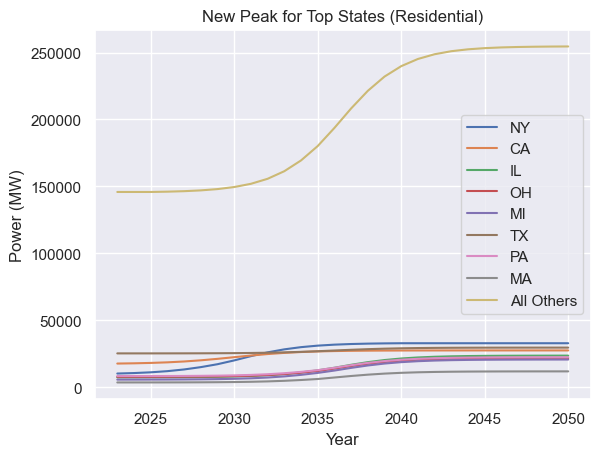

In [54]:
for state in plot_states:
    plt.plot(year_range, state_summary_list[state]["New Peak"], label=state)
plt.title(f"New Peak for Top States (Residential)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("res_new_peak_states.pdf", dpi=150)

plt.show()
    

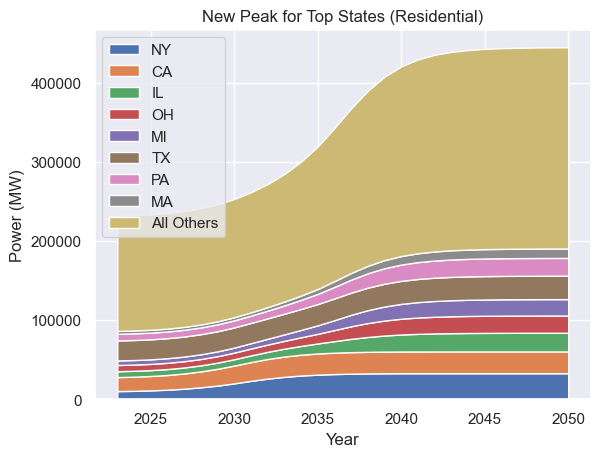

In [55]:
list_plot = [state_summary_list[state]["New Peak"] for state in plot_states]

plt.stackplot(year_range, list_plot, labels=plot_states)
plt.title(f"New Peak for Top States (Residential)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend(loc="upper left")

if save_plots:
    plt.savefig("res_new_peak_states_stack.pdf", dpi=150)
    
plt.show()

### New Supply

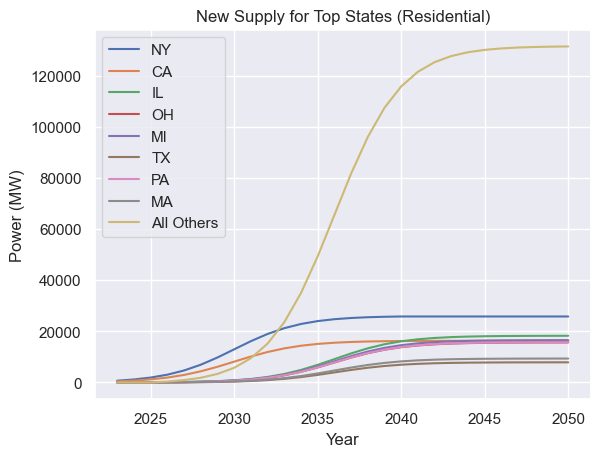

In [56]:
for state in plot_states:
    plt.plot(year_range, state_summary_list[state]["New Supply"], label=state)
plt.title(f"New Supply for Top States (Residential)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("res_new_supply_states.pdf", dpi=150)
    
plt.show()
    

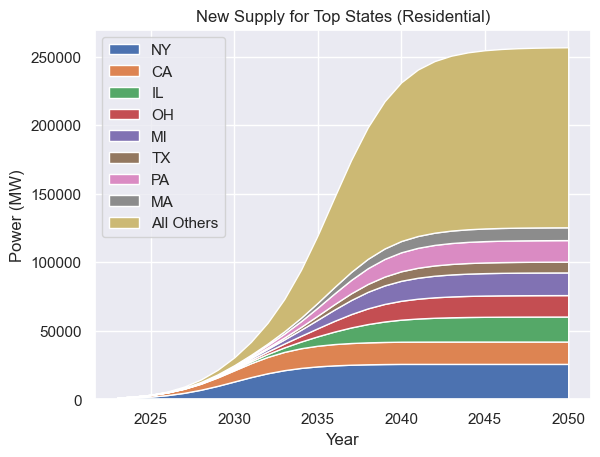

In [57]:
list_plot = [state_summary_list[state]["New Supply"] for state in plot_states]

plt.stackplot(year_range, list_plot, labels=plot_states)
plt.title(f"New Supply for Top States (Residential)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend(loc="upper left")

if save_plots:
    plt.savefig("res_new_supply_states_stack.pdf", dpi=150)
    
plt.show()

### Total Energy Added

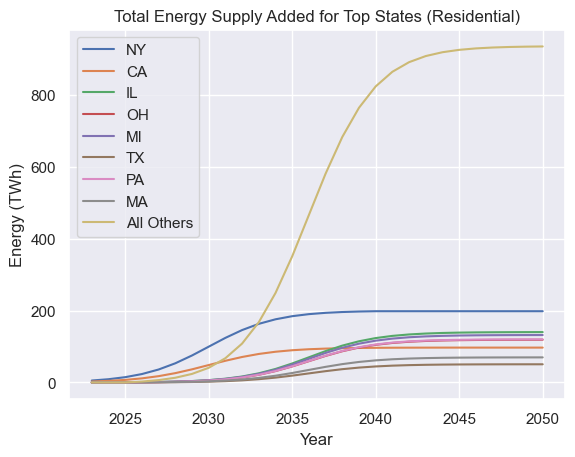

In [58]:
for state in plot_states:
    plt.plot(year_range, state_summary_list[state]["Total Energy Added"], label=state)
plt.title(f"Total Energy Supply Added for Top States (Residential)")   
plt.ylabel("Energy (TWh)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("res_energy_supply_states.pdf", dpi=150)
    
plt.show()

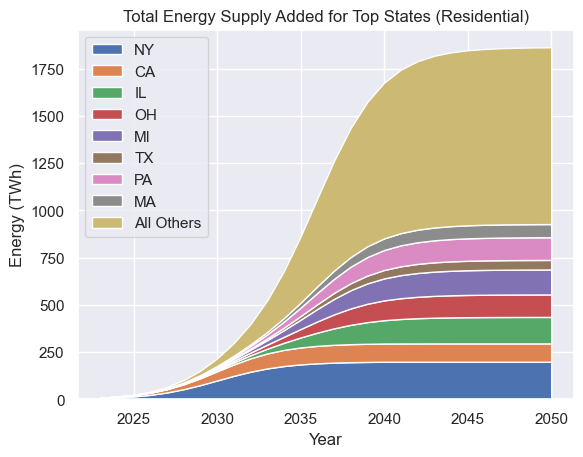

In [59]:
list_plot = [state_summary_list[state]["Total Energy Added"] for state in plot_states]

plt.stackplot(year_range, list_plot, labels=plot_states)
plt.title(f"Total Energy Supply Added for Top States (Residential)")   
plt.ylabel("Energy (TWh)")
plt.xlabel("Year")
plt.legend(loc="upper left")

if save_plots:
    plt.savefig("res_energy_supply_states_stack.pdf", dpi=150)
    
plt.show()

## Plot by RTO